# News Clustering using KMeans Algorithm

In [1]:
import numpy as np
import pandas as pd
from time import time
import articles_data_py3 as articles_data
from pymongo import MongoClient

In [2]:
t0 = time()

## Load data from MongoDB 

In [3]:
client = MongoClient('mongodb://localhost:27017/somanews')
client.somanews.authenticate('ssomanews', 'ssomanews1029')
db = client.get_database('somanews')

crawled_collection = db.get_collection('crawledArticles')
clusters_collection = db.get_collection('articles')

## Select Categories
- 포함 : 경제, 문화, 건강, 과학, 사회, 정치, 스포츠
- 제외 : 종합, 정보없음, 인물, 사설

In [4]:
catelist_path = '../datastore/category.p'
headline_path = '../datastore/headline.p'

In [5]:
train = articles_data.find_recent_articles(crawled_collection, catelist_path)

## Preprocessing
1. Datetime (16-09-11 ~ 16-09-17)
2. Remove stopwords (regex, hanja)
3. POS Tagging with KoNLPy, Mecab
4. Using bigram

In [6]:
import datetime
from konlpy.tag import Mecab
import cnouns
import hanja
import re

In [7]:
mecab = Mecab()

In [8]:
def tokenize(data):
    return [' '.join(e for e in mecab.nouns(data))]

In [9]:
train['title_flat'] = train['title'].apply(lambda text: articles_data.remove_headlines(text, headline_path))
train['title_flat'] = train['title_flat'].apply(lambda text: cnouns.text_cleaning_without_special_ch(text))
train = train[train['title_flat']!='NaN']
title = [tokenize(each[1]['title_flat']) for each in train.iterrows()]

## Training
1. Feature extraction - TfidVectorizer
2. Decomposition - PCA
3. Cluster - KMeans

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [11]:
vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(1,2))
title_flat = [item for sublist in title for item in sublist]
x_list = vectorizer.fit_transform(title_flat)

In [12]:
x_list_100d = PCA(n_components=100).fit_transform(x_list.toarray())
x_list_100d.shape

(2477, 100)

### Scoring

In [13]:
from sklearn.metrics import silhouette_samples, silhouette_score
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Best Silhoutte Score

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

In [15]:
best_score = 0.0
best_k = 0

In [16]:
k_list = []
score_list = []
for k in range(20, 35):
    km = KMeans(n_clusters=k, n_jobs=-1).fit(x_list_100d)
    score = silhouette_score(x_list_100d, km.labels_)
    if best_score < score:
        best_score = score
        best_k = k
    k_list.append(k)
    score_list.append(score)
print("In Clusters =", best_k, ", Best score is : %0.3f" % best_score)

In Clusters = 34 , Best score is : 0.208


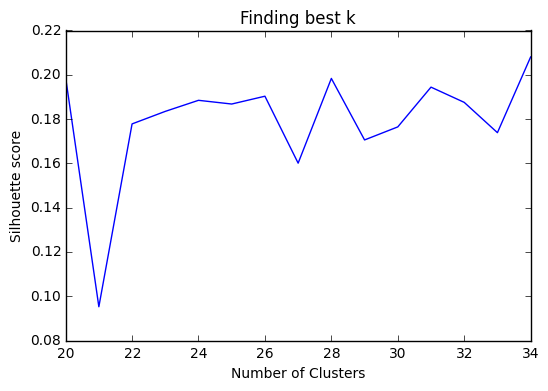

In [17]:
x = k_list
y = score_list
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette score')
plt.title('Finding best k')
plt.plot(x, y)
plt.show()

### K-Means Algorithm

In [18]:
km = KMeans(n_clusters=best_k, n_jobs=-1).fit(x_list_100d)
labels = km.labels_
centroids = km.cluster_centers_
print(km.inertia_)

225.702453863


In [19]:
x_list_vector = x_list_100d.tolist()
train = train.drop(['title_flat'], axis=1)
train['vector'] = x_list_vector
train['cluster'] = labels

## Choose Best Cluster
- Minimum inertia

In [20]:
sample_silhouette_values = silhouette_samples(x_list_100d, labels)
sample_silhouette_score = []
list_silhouette_score = []
best_cluster = []

for i in range(best_k):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[labels == i]    
    list_silhouette_score.append(abs(ith_cluster_silhouette_values.mean()))

list_silhouette_score.sort(reverse=True)
sample_silhouette_score = list_silhouette_score[:12]

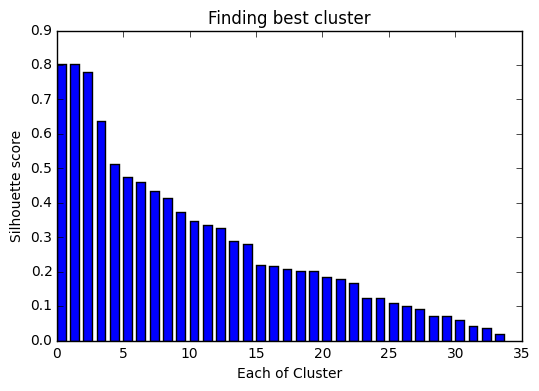

In [21]:
x = [x for x in range(best_k)]
y = list_silhouette_score
width = 1/1.5
plt.xlabel('Each of Cluster')
plt.ylabel('Silhouette score')
plt.title('Finding best cluster')
plt.bar(x, y, width)
plt.show()

In [22]:
sample_silhouette_score

[0.8028077423491885,
 0.8023040882509368,
 0.77812522285141816,
 0.63786470167047915,
 0.51271830769482052,
 0.47585136370267733,
 0.4601668858257057,
 0.43499480479759045,
 0.41273846214851301,
 0.37302549764142312,
 0.34634541746809472,
 0.33561369638813454]

In [23]:
for i in range(best_k):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[labels == i]
        
    if abs(ith_cluster_silhouette_values.mean()) in sample_silhouette_score:
        best_cluster.append(i)

In [24]:
train = train[train['cluster'].isin(best_cluster)]
train.cluster.unique()

array([ 2, 19, 27, 32, 31, 13, 16,  1, 24, 20, 22, 11])

## Result

In [25]:
cluster_data = []

for cluster_index in range(best_k):
    if cluster_index in best_cluster:
        cluster_data.append(train[train['cluster'] == cluster_index])
    
for i, d in enumerate(cluster_data):
    print('Cluster %d:' % (i), 'Size %d' % (len(d)))

    display(d[['title', 'category']].sample(min(len(train.cluster.unique()), len(d))))
    print('\n\n')

Cluster 0: Size 7


,title,category
975,한진해운 선박 또 압류돼,경제 > 경제일반
3275,한진해운 화물 95.5% 하역… 물류대란 두달만에 마무리,뉴스 > 경제 > 경제일반
2944,한진해운 9월 말 이후 운송대금 583억여원 받아,경제 > 경제일반
2814,한진해운 물류대란 마무리 단계…“97척 중 3척 하역만 남아”,경제 > 경제일반
1106,"한진해운, 선박 중국서 또 가압류…선박 총 5척·선원 95명 억류",마켓·비즈 > 경제일반
2946,"한진해운 이후, 韓 해운업은 어디로",마켓·비즈 > 경제일반
3100,“제2의 한진해운 막으려면 해운·조선 자금 흐름 이어야”,마켓·비즈 > 경제일반





Cluster 1: Size 13


,title,category
12,새 대통령 비서실장에 한광옥 내정,정치 > 청와대
1211,한광옥 실장 “대통령 2선후퇴 건의할 생각 없어”,뉴스 > 정치 > 정치일반
4131,"트럼프의 최측근 3인방, 비서실장 등 백악관 요직 예고",뉴스 > 국제 > 미국/북미
496,"[사설]한광옥 비서실장, 직언하지 못할 거면 시작도 말라",뉴스 > 정치 > 정치일반
16,"대통령 비서실장 한광옥, 정무수석 허원제",정치 > 청와대
1221,"국회 인사 온 한광옥에 野圈 불편한 기색… 박지원 ""DJ 비서실장까지 지낸 분이…""",정치
514,새 비서실장에 'DJ맨' 한광옥,정치 > 청와대
2114,"한광옥 靑 비서실장 ""박 대통령, 침울한 상태""",정치 > 정치일반
1543,"한광옥 대통령 비서실장 ""광화문 광장에서 보여준 국민 준엄한 뜻, 매우 무겁게 느껴""",정치 > 국회·정당
8,"신임 대통령 비서실장에 DJ 비서실장, 한광옥 국민대통합위원장",정치 > 국회·정당





Cluster 2: Size 8


,title,category
3419,韓·日 군사협정 서두르는 정부… 野 추천 총리가 받아들일까,정치 > 외교
2356,11월 8일 함께하는 교육 정보,사회 > 교육
2849,"정부, '최순실 게이트' 틈타 한일군사정보보호협청 체결 서둘러",정치 > 국방·외교
3161,한·일 군사정보협정 ‘속전속결’ 체결 강행,정치 > 국방·외교
3097,한일 군사정보협정 가속…야 “어수선한 틈 밀어붙이기” 반발,정치 > 국방·북한
3860,"국방부 “한일 군사정보협정, 주요 내용 의견 일치”",정치 > 국방·북한
2827,"이 와중에…국방부, ‘한일 군사협정’ 2차 협상도 강행",정치 > 국방·북한
3377,韓日 군사정보협정 9일 2차협의… 타결 임박,뉴스 > 사회 > 사회일반





Cluster 3: Size 14


,title,category
1335,고 백남기 농민 장례미사 명동성당서 봉헌···“얼마나 더 많은 사람이 희생돼야 죽음...,사회 > 사회일반
1343,[1신] 백남기 농민 영결식 2만여명 추모행렬,사회 > 사회일반
1350,[4신] 백남기 영결식 2만여명 “싸움은 이제 시작”,사회 > 사회일반
1348,"""얼마나 더 많은 사람이 희생돼야 죽음을 알게 될까"" 고 백남기 농민 장례 엄수",사회 > 사회일반
1352,"""국가가 어둠에 잠겨 있다"" 고 백남기 농민 영결식 추도사",사회 > 사회일반
1684,금남로에 시민 3000명…백남기 농민 ‘마지막 길’ 외롭지 않았다,사회 > 사회일반
1620,백남기 농민 5·18 민주열사 묘역에 잠들다,사회 > 전국
1577,들꽃같은 삶을 살았던 의인 백남기 농민 영면,사회 > 전국
1375,“전두환 비 밟고 간다”…백남기 농민 묻힐 5·18 구 묘역,사회 > 전국
1342,"박원순, 백남기 영결식서 “박대통령 하야 기필코 이뤄낼 것”",사회 > 사회일반





Cluster 4: Size 9


,title,category
3691,"검찰, ‘문고리 3인방’ 이재만·안봉근 자택 압수수색",사회 > 사회일반
3714,안봉근 이재만 전 비서관도 압색...문고리 3인방 모두 수사대상,사회 > 사회일반
513,'문고리 3인방' 없는 첫 비서진… DJ맨에게 소통 열쇠 맡겼다,정치 > 청와대
2487,[사설]靑 ‘문고리 3인방’ 박 대통령 아닌 최순실에게 충성 바쳤나,뉴스 > 정치 > 정치일반
801,"[속보]검찰, ‘문고리 3인방’ 정호성 전 비서관 체포",사회 > 법원·검찰
802,"검찰, 정호성 전 비서관 어젯밤 전격 체포",사회 > 사회일반
1245,朴대통령의 18년 手足 '문고리 3인방' 사법처리 초읽기,사회 > 법원ㆍ검찰ㆍ경찰
805,"검찰, ‘문고리 3인방’ 정호성 전 비서관 어젯밤 체포",사회 > 사회일반
3694,"[속보]검찰, ‘문고리’ 안봉근·이재만 등 자택 4곳 압수수색",사회 > 법원·검찰





Cluster 5: Size 10


,title,category
2166,'제2의 브렉시트 일어나나'...세계는 미국 대선을 어떻게 지켜봤나,국제 > 국제일반
368,"영국 고등법원 “리스본조약 50조 발동, 정부 아닌 의회 권한”…브렉시트 장기화 예고",국제 > 유럽
1713,[2016 미국의 선택]‘미국판 브렉시트’ 일어날지도 모른다,국제 > 미국·중남미
672,"“EU 공식탈퇴 하려면 의회 표결절차 거쳐라” 英법원, 브렉시트 제동",뉴스 > 국제 > 국제일반
558,"英고법, 브렉시트 협상 일정에 급제동",국제 > 유럽
4123,反이민 정서 자극한 포퓰리즘 선거… 브렉시트와 닮은꼴,뉴스 > 국제 > 미국/북미
3647,트럼프 우세에 국내 금값 급등…브렉시트 이후 최대폭,경제 > 경제일반
56,콜린스 선정 2016년 올해의 단어는 ‘브렉시트’,국제 > 국제일반
1899,메이 “브렉시트 결정 되돌리는 일 없을 것”,뉴스 > 국제 > 국제일반
1941,美 누가 이겨도 ‘보호무역’… 트럼프 당선땐 브렉시트급 충격,뉴스 > 경제 > 경제일반





Cluster 6: Size 6


,title,category
4033,[간추린 뉴스]두산밥캣 공모주 청약 미달 外,뉴스 > 경제 > 경제일반
2221,"두산밥캣 공모가 3만원 확정, 상장 재도전",경제 > 경제일반
2443,"두산밥캣, 공모가 낮춰 상장 재도전",경제 > 경제일반
3827,트럼프 당선 때문에? 두산밥캣 공모주 청약 미달,마켓·비즈 > 경제일반
2030,두산밥캣 공모가 3만원 확정···8일부터 일반 청약,마켓·비즈 > 금융·재테크
3019,"두산밥캣 청약 첫날, 경쟁률 0.3대1 ‘불안한 출발’",마켓·비즈 > 금융·재테크





Cluster 7: Size 16


,title,category
2215,"'굿판 참여' 박승주 안전처 장관 내정자 ""환태평양 지진대가 활동해서"" 해명",사회 > 사회일반
2237,박승주 국민안전처 장관 내정자 ‘광화문 굿판’ 참석 해명 들어보니,사회 > 사회일반
2118,"‘전생 안전처’ 장관? 박승주 후보자, 전생 체험 고백 책도 썼다",사회 > 사회일반
2342,[카드뉴스] 장관 내정자와 굿판,사회 > 카드뉴스
3933,박승주 국민안전처 장관 내정자 일주일만에 자진사퇴,전국 > 전국일반
2435,광화문 한복판 굿판 참석하고 전봉준 만났다는 장관 내정자,정치 > 정치일반
4168,"'굿판 논란' 박승주 안전처장관 내정자, 결국 자진 사퇴",사회
2091,"박승주 국민안전처 장관 내정자, 굿판 참석·47회 전생 고백 논란",사회 > 전국
2048,"박승주 안전처장관 내정자, ""전봉준 장군이 찾아왔다"" 주장, 굿판 참석도",사회 > 사회일반
2541,[횡설수설/송평인]안전처 장관 후보자의 굿판,뉴스 > 정치 > 정치일반





Cluster 8: Size 6


,title,category
1608,김병준 총리 내정자 “내가 왜 자진 사퇴하느냐”고 하지만…,정치 > 정치일반
1733,"김병준 ""자진사퇴 없다… 이렇게 어려울지 몰랐을 것 같나""",정치
2484,[박근혜·최순실 게이트]“여·야·청서 새 후보 내면 사라질 것” 김병준 총리 지명자...,정치 > 정치일반
1340,김병준 총리후보 둘째딸 결혼식…자진사퇴? “그런 일 없다”,사회 > 사회일반
3996,[박근혜·최순실 게이트]박승주 내정자 자진 사퇴,정치 > 정치일반
1341,김병준 국무총리 내정자 “자진사퇴는 없다”,사회 > 사회일반





Cluster 9: Size 5


,title,category
707,‘엘시티 비리’ 관련 부산시청 등 4곳 압수수색,뉴스 > 사회 > 사회일반
211,해운대 엘시티 비리 의혹 관련 부산시청 등 압수수색,사회 > 전국
451,‘엘시티 특혜’ 부산시청 압수수색,사회 > 법원·검찰
522,'엘시티 비리' 부산시청 등 압수수색,사회 > 법원ㆍ검찰ㆍ경찰
109,엘시티 인허가 관련 부산시청·해운대구청 등 4곳 압수수색,사회 > 법원·검찰





Cluster 10: Size 15


,title,category
3963,“역사 국정교과서 반대” 학생·시민단체 ‘1인 시위’ 돌입,사회 > 교육·입시
289,“국정 교과서 반대” 밝힌 김병준 총리지명자에 당황한 교육부,사회 > 교육
1440,"조희연 서울교육감, “‘최순실 사태’ 역사교과서 국정화 철회 촉구”",사회 > 사회일반
2190,민병희 강원교육감 “`최순실 교과서’ 의혹 역사교과서 국정화 계획 철회해야”,사회 > 전국
737,김병준 “국정 역사교과서 합당한 것인지 의문”,뉴스 > 정치 > 정치일반
2217,"김승환 전북교육감 “국정교과서 도입, 최우선 중단돼야할 정책”",사회 > 사회일반
3715,“박근혜 퇴진과 역사교과서 국정화 중단하라”,사회 > 전국
2957,이재정 경기교육감 “역사교과서 국정화 철회돼야”,사회 > 교육·입시
3855,교육부 보고 있나? 학생도 학부모도 “국정역사교과서 반대”,사회 > 교육·입시
449,역사 국정교과서 강행하던 교육부 ‘난감’,사회 > 교육·입시





Cluster 11: Size 4


,title,category
705,‘국보급’ 동의보감 초판본 되찾았다,뉴스 > 사회 > 사회일반
452,‘국보급’ 동의보감 초판본 등 도난 문화재 3800점 찾았다,사회 > 법원·검찰
533,"도난당한 국보급 동의보감, 2000만원에 사찰까지 흘러가…",사회 > 사건ㆍ사고
216,동의보감·대명률 등 국보급 도난문화재 3800점 압수,사회 > 전국


## Save Dataframe to MongoDB

In [26]:
client = MongoClient('mongodb://localhost:27017/somanews')
client.somanews.authenticate('ssomanews', 'ssomanews1029')
db = client.get_database('somanews')
articles = db.get_collection('articles')

In [27]:
articles.insert_many(train.to_dict(orient='records'))
client.close()

In [28]:
print("Done in %0.3fs." % (time() - t0))

Done in 84.278s.
